## Load data

In [131]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [132]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 5 columns (57 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [133]:
# # Split into two dataframes, printing result
# df_ones = df[df['METHUSE']==1]
# df_twos = df[df['METHUSE']==2]
# print('Classes before down-sampling:', len(df_ones), len(df_twos))
#
# # Sample down df_twos to the length of df_ones, printing result
# ratio = len(df_ones)/len(df_twos
# df_twos = df_twos.sample(frac=ratio)
# print('Classes after down-sampling:', len(df_ones), len(df_twos))
#
# # Recombine and shuffle for good measure
# df = pd.concat([df_ones, df_twos], axis=0)
# df = df.sample(frac=1).reset_index(drop=True)

In [134]:
df

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,EMPLOY,METHUSE,...,STIMFLG,BENZFLG,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,IDU,ALCDRUG
0,2,2,1,7,-9,3,1,0,3,2,...,0,0,0,0,0,0,0,0,1,3
1,2,3,1,7,-9,2,3,0,4,1,...,0,0,0,0,0,0,0,0,1,2
2,2,1,2,7,-9,5,2,0,4,1,...,0,0,0,0,0,0,0,0,1,2
3,2,3,1,7,-9,3,3,0,4,1,...,0,0,0,0,0,0,0,0,1,2
4,2,3,1,7,-9,1,2,0,2,1,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524129,56,-9,2,6,-9,0,6,0,3,2,...,0,0,0,0,0,0,0,0,0,2
524130,56,-9,2,6,1,2,7,0,3,2,...,0,0,0,0,0,0,0,0,0,2
524131,56,3,1,7,-9,3,2,0,3,2,...,0,0,0,0,1,0,0,0,0,3
524132,56,1,1,7,3,0,7,0,4,2,...,0,0,0,0,0,0,0,0,0,2


## Make dataset human-readable

In [135]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

In [136]:
# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

In [137]:
df2

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,...,BENZFLG,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,IDU,ALCDRUG,DETEMPLOY
0,AK,Grade9To11,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,Individual,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,AlcoholAndDrugs,Unemployed
1,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,2PriorTreatments,OtherHealthCareProvider,0Arrest,MethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,OtherNotInLaborForce
2,AK,Grade8OrLess,NowMarried,AmbulatoryNonIntensiveOutpatient,Unknown,5PlusPriorTreatments,DrugCareProvider,0Arrest,MethUse,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,RetiredOrDisabled
3,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,OtherHealthCareProvider,0Arrest,MethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,OtherNotInLaborForce
4,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,1PriorTreatments,DrugCareProvider,0Arrest,MethUse,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,PartTime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524129,WY,Unknown,NowMarried,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,OtherReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,Unemployed
524130,WY,Unknown,NowMarried,AmbulatoryIntensiveOutpatient,Court,2PriorTreatments,CourtReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,Unemployed
524131,WY,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,DrugCareProvider,0Arrest,NoMethUse,Yes,...,NotReported,NotReported,NotReported,Reported,NotReported,NotReported,NotReported,NoIDU,AlcoholAndDrugs,Unemployed
524132,WY,Grade8OrLess,NeverMarried,AmbulatoryNonIntensiveOutpatient,ProbationOrParole,0PriorTreatments,CourtReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,InstitutionResident


## Make machine-readable dataset (for exporting)

# Logistic Regression

In [55]:
vc.iloc[0]

191417

In [60]:
# Remove dependent variable
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# df2.to_csv('human_readable_data.csv', index=False)

# Identify the most common group within each column from df2
reference_group_columns = []
columns = [c for c in df2.columns if c != 'METHUSE']
for col in columns:
    vc = df2.value_counts(col)
    dfl = len(df2)
    name = f"{col}_{vc.index[0]}"
    reference_group_columns.append(name)
    variable_share = round(100*vc.iloc[0]/dfl, 2)
    print(col, vc.index[0], variable_share)

# Replace HERFLG_Reported with HERFLG_NotReported for consistency with other FLG variables
reference_group_columns = list(map(lambda x: x.replace('HERFLG_Reported', 'HERFLG_NotReported'), reference_group_columns))

STFIPS NY 17.23
EDUC Grade12OrGED 48.35
MARSTAT NeverMarried 56.62
SERVICES AmbulatoryNonIntensiveOutpatient 50.17
DETCRIM Unknown 89.01
NOPRIOR 0PriorTreatments 28.14
PSOURCE Individual 57.16
ARRESTS 0Arrest 85.36
PSYPROB No 47.05
PREG Unknown 65.51
GENDER Male 63.12
VET NotVeteran 92.43
LIVARAG IndependentLiving 62.33
DAYWAIT 0DaysWait 41.79
DSMCRIT OpioidDependence 59.11
AGE Age30To34 21.21
RACE White 69.39
ETHNIC NonHispanic 83.48
PRIMINC Unknown 35.52
SUB1 Heroin 78.22
SUB2 None 28.46
SUB3 None 61.67
ROUTE1 Injection 48.34
ROUTE2 Unknown 38.26
ROUTE3 Unknown 73.98
FREQ1 DailyUse 58.35
FREQ2 Unknown 38.06
FREQ3 Unknown 73.6
FRSTUSE1 18To20y 20.41
FRSTUSE2 Unknown 40.31
FRSTUSE3 Unknown 74.5
HLTHINS Unknown 46.45
PRIMPAY Unknown 56.92
FREQ_ATND_SELF_HELP NoAttendance 63.35
ALCFLG NotReported 87.31
COKEFLG NotReported 74.75
MARFLG NotReported 83.46
HERFLG Reported 80.0
METHFLG NotReported 99.1
OPSYNFLG NotReported 73.44
PCPFLG NotReported 99.82
HALLFLG NotReported 99.82
MTHAMFLG NotR

In [66]:
df3 = df2.copy()

# Convert categorical variables to dummy variables
df3 = pd.get_dummies(df3)

# Drop reference group columns (necessary for logistic regression)
df3 = df3.drop(columns=reference_group_columns)

# Add intercept
df3.insert(0, 'Intercept', 1)

# Save dataframe to csv and show below
# df3.to_csv('data.csv', index=False)
state_columns = [i for i in df3.columns if i.startswith('STFIPS')]

# Add interaction columns of state and homeless status
for state in state_columns:
    two_letter_state_code = state[-2:]
    interaction_name = 'Homeless_' + two_letter_state_code
    # df3[interaction_name] = df3[state]*df3['LIVARAG_Homeless']
    df3 = df3.assign(interaction_name=df3[state] * df3['LIVARAG_Homeless'])

df3 = df3.astype(int)

In [68]:
df3

,Intercept,METHUSE,STFIPS_AK,STFIPS_AL,STFIPS_AR,STFIPS_AZ,STFIPS_CA,STFIPS_CO,STFIPS_CT,STFIPS_DC,...,DETEMPLOY_FullTime,DETEMPLOY_Homemaker,DETEMPLOY_InstitutionResident,DETEMPLOY_OtherNotInLaborForce,DETEMPLOY_PartTime,DETEMPLOY_RetiredOrDisabled,DETEMPLOY_Student,DETEMPLOY_Unknown,DETEMPLOY_UnknownNotInLaborForce,interaction_name
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524130,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524131,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524132,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [65]:
# df3_1 = df3.copy().head(100000)
# df3_1 = df3_1.iloc[:,0:5]

# # Define dependent variable and train-test split
# X = df3_1.drop('METHUSE', axis=1)
# # X = X.iloc[:,1:5]
# y = df3_1['METHUSE']
#
# X

In [15]:
# len(df3_1.columns)
# X = df3_1.drop('METHUSE', axis=1)
# # X.iloc[:,276:301]
# X.iloc[:,:2]

In [16]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# import statsmodels.api as sm
#
# # Reduce size for testing
# df3_1 = df3.copy()
# # df3_1 = df3_1.iloc[:,0:5]
#
# # Define dependent variable and train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=24)
#
# # Create and train a logistic regression model
# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(X_train, y_train)
#
# # Get the coefficients and convert to numpy array
# coefficients = np.array(logistic_model.coef_)
#
# # Calculate the marginal effects using the MEM method
# marginal_effects = np.mean(X_train, axis=0) * coefficients
#
# print("Marginal Effects:")
# print(marginal_effects)

In [17]:
# X = df3_1.drop('METHUSE', axis=1)
# [c for c in X.columns]

In [27]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reduce size for testing
df3_1 = df3.copy()

# Define dependent variable and train-test split
y = df3_1['METHUSE']
X = df3_1.drop('METHUSE', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LogisticRegressionCV for cross-validated grid search
# 'Cs' is a list of candidate values for C
# Set 'cv' to the number of desired folds for cross-validation
# model = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, penalty='l1', solver='liblinear')

# model.fit(X_train_scaled, y_train)
#
# # Get the best C value
# best_C = model.C_[0]
# print(f"Best C value: {best_C}")
#
# # Evaluate the model on the test set
# accuracy = model.score(X_test_scaled, y_test)
# print(f"Accuracy on the test set: {accuracy:.2f}")


lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lasso_model.fit(X_train_scaled, y_train)

# Print the coefficients
print("Coefficients after Lasso regularization:")
print(lasso_model.coef_)

accuracy = lasso_model.score(X_test_scaled, y_test)
print(f"Accuracy on the test set: {accuracy:.2f}")

Coefficients after Lasso regularization:
[[ 0.00000000e+00  7.37274540e-02 -4.06582861e-02  5.99742578e-02
  -2.37342463e-01  2.40944715e-01  1.39711342e-01 -1.70159237e-01
  -7.49601094e-02  2.10880593e-01 -1.25460624e-01 -6.77883859e-03
   2.27577744e-02 -1.13703830e-02 -2.95121511e-01 -4.22104094e-02
  -2.37131111e-02  4.07755813e-02 -1.54653312e-01 -2.68065466e-01
  -2.41858941e-02  1.84183101e-01  9.23413361e-02  1.23733026e-01
  -4.94647563e-02 -1.64789347e-01 -6.48989908e-02 -4.35642341e-01
  -1.28774590e-02  4.56510772e-02 -1.88322586e-03  6.90025960e-01
   2.35118322e-01  1.58020703e-02  5.13003174e-02 -6.23299561e-01
   1.59285622e-01 -5.70765919e-02  1.33785111e-01  1.66324646e-02
   5.16308948e-02 -4.70812003e-01  1.53959241e-01  1.05309224e-01
  -9.75879272e-01  1.71862045e-01 -9.78674546e-02 -7.67821782e-02
  -3.58810155e-03 -2.51956063e-02  1.78426143e-04  4.29766029e-02
   1.19763998e-01 -1.57187283e-02  3.27064350e-03 -5.96273607e-03
  -2.47594398e-01 -7.85415425e-02 -

In [30]:
df5 = pd.DataFrame()
df5['column_name'] = X.columns
df5['coefficient'] = lasso_model.coef_[0]
# df5.to_csv('variables_removed_from_lasso.csv')
df5

,column_name,coefficient
0,Intercept,0.000000
1,STFIPS_AK,0.073727
2,STFIPS_AL,-0.040658
3,STFIPS_AR,0.059974
4,STFIPS_AZ,-0.237342
...,...,...
325,Homeless_UT,-0.022680
326,Homeless_VA,0.000000
327,Homeless_VT,-0.006096
328,Homeless_WI,-0.019710


In [ ]:
stop

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Reduce size for testing
df3_1 = df3.copy()
df3_1 = df3.astype(int)
# df3_1 = df3_1.iloc[:,0:5]

# Define dependent variable and train-test split
y = df3_1['METHUSE']
X = df3_1.drop('METHUSE', axis=1)
X = X[[
 'Intercept',
 'STFIPS_AK',
 'STFIPS_AL',
 'STFIPS_AR',
 'STFIPS_AZ',
 'STFIPS_CA',
 'STFIPS_CO',
 'STFIPS_CT',
 'STFIPS_DC',
 'STFIPS_DE',
 'STFIPS_GA',
 'STFIPS_HI',
 'STFIPS_IA',
 'STFIPS_ID',
 'STFIPS_IL',
 'STFIPS_IN',
 'STFIPS_KS',
 'STFIPS_KY',
 'STFIPS_LA',
 'STFIPS_MA',
 'STFIPS_MD',
 'STFIPS_ME',
 'STFIPS_MI',
 'STFIPS_MN',
 'STFIPS_MO',
 'STFIPS_MS',
 # 'STFIPS_MT', #failed to converge after 10k interactions (w OK, w/o interactions) # Singular
 'STFIPS_NC',
 'STFIPS_ND',
 'STFIPS_NE',
 'STFIPS_NH',
 'STFIPS_NJ',
 'STFIPS_NM',
 'STFIPS_NV',
 'STFIPS_OH',
 # 'STFIPS_OK', # converged after 592 iterations (w/o MT or interactions)
 'STFIPS_PA',
 'STFIPS_PR',
 'STFIPS_RI',
 'STFIPS_SC',
 'STFIPS_SD',
 'STFIPS_TN',
 'STFIPS_TX',
 'STFIPS_UT',
 # 'STFIPS_VA',
 'STFIPS_VT',
 'STFIPS_WI',
 'STFIPS_WY',
 'EDUC_1To3yCollege',
 'EDUC_4yCollegePlus',
 'EDUC_Grade8OrLess',
 'EDUC_Grade9To11',
 'EDUC_Unknown',
 'MARSTAT_DivorcedOrWidowed',
 'MARSTAT_NowMarried',
 'MARSTAT_Separated',
 'MARSTAT_Unknown',
 'SERVICES_AmbulatoryDetox',
 'SERVICES_AmbulatoryIntensiveOutpatient',
 'SERVICES_Detox24hFreeStandingRes',
 'SERVICES_Detox24hHospitalInpatient',
 'SERVICES_RehabResHospitalNonDetox',
 'SERVICES_RehabResLongTerm',
 'SERVICES_RehabResShortTerm',
 'DETCRIM_Adjudication',
 'DETCRIM_Court',
 'DETCRIM_DUI',
 'DETCRIM_DiversionaryProgram',
 'DETCRIM_Other',
 'DETCRIM_OtherLegalEntity',
 'DETCRIM_Prison',
 'DETCRIM_ProbationOrParole',
 'NOPRIOR_1PriorTreatments',
 'NOPRIOR_2PriorTreatments',
 'NOPRIOR_3PriorTreatments',
 'NOPRIOR_4PriorTreatments',
 'NOPRIOR_5PlusPriorTreatments',
 'NOPRIOR_Unknown',
 'PSOURCE_CourtReferral',
 'PSOURCE_DrugCareProvider',
 'PSOURCE_Employer',
 'PSOURCE_OtherHealthCareProvider',
 'PSOURCE_OtherReferral',
 'PSOURCE_School',
 'PSOURCE_Unknown',
 'ARRESTS_1Arrest',
 'ARRESTS_2PlusArrest',
 'ARRESTS_Unknown',
 'PSYPROB_Unknown',
 'PSYPROB_Yes',
 'PREG_NotPregnant',
 'PREG_Pregnant',
 'GENDER_Female',
 'GENDER_Unknown',
 'VET_Unknown',
 'VET_Veteran',
 'LIVARAG_DependLiving',
 'LIVARAG_Homeless',
 'LIVARAG_Unknown',
 'DAYWAIT_15To30DaysWait',
 'DAYWAIT_1To7DaysWait',
 'DAYWAIT_31PlusDaysWait',
 'DAYWAIT_8To14DaysWait',
 'DAYWAIT_Unknown',
 'DSMCRIT_ADDOrBehaviorDisorder',
 'DSMCRIT_AlcoholAbuse',
 'DSMCRIT_AlcoholDependence',
 'DSMCRIT_AlcoholDisorder',
 'DSMCRIT_AlcoholIntoxication',
 'DSMCRIT_AnxietyDisorder',
 'DSMCRIT_BipolarDisorder',
 'DSMCRIT_CannabisAbuse',
 'DSMCRIT_CannabisDependence',
 'DSMCRIT_CocaineAbuse',
 'DSMCRIT_CocaineDependence',
 'DSMCRIT_DepressiveDisorder',
 'DSMCRIT_OpioidAbuse',
 'DSMCRIT_OtherMentalHealthCondition',
 'DSMCRIT_OtherSubstanceAbuse',
 'DSMCRIT_OtherSubstanceDependence',
 'DSMCRIT_SchizopheniaOrPsychDisorder',
 'DSMCRIT_SubstanceDisorder',
 'DSMCRIT_Unknown',
 'AGE_Age12To14',
 'AGE_Age15To17',
 'AGE_Age18To20',
 'AGE_Age21To24',
 'AGE_Age25To29',
 'AGE_Age35To39',
 'AGE_Age40To44',
 'AGE_Age45To49',
 'AGE_Age50To54',
 'AGE_Age55To64',
 'AGE_Age65Plus',
 'RACE_AlaskaNative',
 'RACE_AmericanIndian',
 'RACE_Asian',
 'RACE_AsianOrPacificIslander',
 'RACE_Black',
 'RACE_OtherSingleRace',
 'RACE_PacificIslander',
 'RACE_TwoPlusRaces',
 'RACE_Unknown',
 'ETHNIC_CubanOrOther',
 'ETHNIC_Mexican',
 'ETHNIC_PuertoRican',
 'ETHNIC_Unknown',
 'ETHNIC_UnspecifiedHispanic',
 'PRIMINC_None',
 'PRIMINC_Other',
 'PRIMINC_PublicAssist',
 'PRIMINC_RetireOrDisable',
 'PRIMINC_Wages',
 'SUB1_NoScriptMethadone',
 'SUB1_OtherOpioidSynthetics',
 'SUB2_Alcohol',
 'SUB2_Barbiturates',
 'SUB2_Benzo',
 'SUB2_CokeCrack',
 'SUB2_Hallucinogenics',
 'SUB2_Heroin',
 'SUB2_Inhalants',
 'SUB2_MethSpeed',
 'SUB2_NoScriptMethadone',
 'SUB2_OtherAmphetamines',
 'SUB2_OtherDrugs',
 'SUB2_OtherOpioidSynthetics',
 'SUB2_OtherSedatives',
 'SUB2_OtherStimulants',
 'SUB2_OtherTranqs',
 'SUB2_OverTheCounter',
 'SUB2_PCP',
 'SUB2_PotHash',
 'SUB2_Unknown',
 # 'SUB3_Alcohol',
 # 'SUB3_Barbiturates',
 # 'SUB3_Benzo',
 # 'SUB3_CokeCrack',
 # 'SUB3_Hallucinogenics',
 # 'SUB3_Heroin',
 # 'SUB3_Inhalants',
 # 'SUB3_MethSpeed',
 # 'SUB3_NoScriptMethadone',
 # 'SUB3_OtherAmphetamines',
 # 'SUB3_OtherDrugs',
 # 'SUB3_OtherOpioidSynthetics',
 # 'SUB3_OtherSedatives',
 # 'SUB3_OtherStimulants',
 # 'SUB3_OtherTranqs',
 # 'SUB3_OverTheCounter',
 # 'SUB3_PCP',
 # 'SUB3_PotHash',
 # 'SUB3_Unknown',
 'ROUTE1_Inhalation',
 'ROUTE1_Oral',
 'ROUTE1_Other',
 'ROUTE1_Smoking',
 'ROUTE1_Unknown',
 'ROUTE2_Inhalation',
 'ROUTE2_Injection',
 'ROUTE2_Oral',
 'ROUTE2_Other',
 'ROUTE2_Smoking',
 # 'ROUTE3_Inhalation',
 # 'ROUTE3_Injection',
 # 'ROUTE3_Oral',
 # 'ROUTE3_Other',
 # 'ROUTE3_Smoking',
 'FREQ1_NoUsePastMonth',
 'FREQ1_SomeUse',
 'FREQ1_Unknown',
 'FREQ2_DailyUse',
 'FREQ2_NoUsePastMonth',
 'FREQ2_SomeUse',
 # 'FREQ3_DailyUse',
 # 'FREQ3_NoUsePastMonth',
 # 'FREQ3_SomeUse',
 'FRSTUSE1_11yLess',
 'FRSTUSE1_12To14y',
 'FRSTUSE1_15To17y',
 'FRSTUSE1_21To24y',
 'FRSTUSE1_25To29y',
 'FRSTUSE1_30yPlus',
 'FRSTUSE1_Unknown',
 'FRSTUSE2_11yLess',
 'FRSTUSE2_12To14y',
 'FRSTUSE2_15To17y',
 'FRSTUSE2_18To20y',
 'FRSTUSE2_21To24y',
 'FRSTUSE2_25To29y',
 'FRSTUSE2_30yPlus',
 # 'FRSTUSE3_11yLess',
 # 'FRSTUSE3_12To14y',
 # 'FRSTUSE3_15To17y',
 # 'FRSTUSE3_18To20y',
 # 'FRSTUSE3_21To24y',
 # 'FRSTUSE3_25To29y',
 # 'FRSTUSE3_30yPlus',
 'HLTHINS_Medicaid',
 'HLTHINS_MedicareOrOther',
 'HLTHINS_None',
 'HLTHINS_PrivateInsurance',
 'PRIMPAY_Medicaid',
 'PRIMPAY_Medicare',
 'PRIMPAY_NoCharge',
 'PRIMPAY_Other',
 'PRIMPAY_OtherGovtPayment',
 'PRIMPAY_PrivateInsurance',
 'PRIMPAY_SelfPay',
 'FREQ_ATND_SELF_HELP_1To3TimesPastMonth',
 'FREQ_ATND_SELF_HELP_4To7TimesPastMonth',
 'FREQ_ATND_SELF_HELP_8To30TimesPastMonth',
 'FREQ_ATND_SELF_HELP_SomeAttendance',
 'FREQ_ATND_SELF_HELP_Unknown',
 'ALCFLG_Reported',
 'COKEFLG_Reported',
 'MARFLG_Reported',
 'HERFLG_Reported',
 'METHFLG_Reported',
 'OPSYNFLG_Reported',
 'PCPFLG_Reported',
 'HALLFLG_Reported',
 'MTHAMFLG_Reported',
 'AMPHFLG_Reported',
 'STIMFLG_Reported',
 'BENZFLG_Reported',
 'TRNQFLG_Reported',
 'BARBFLG_Reported',
 'SEDHPFLG_Reported',
 'INHFLG_Reported',
 'OTCFLG_Reported',
 'OTHERFLG_Reported',
 'IDU_IDU',
 'ALCDRUG_AlcoholAndDrugs',
 'DETEMPLOY_FullTime',
 'DETEMPLOY_Homemaker',
 'DETEMPLOY_InstitutionResident',
 'DETEMPLOY_OtherNotInLaborForce',
 'DETEMPLOY_PartTime',
 'DETEMPLOY_RetiredOrDisabled',
 'DETEMPLOY_Student',
 'DETEMPLOY_Unknown',
 'DETEMPLOY_UnknownNotInLaborForce',
 'Homeless_AK',
 'Homeless_AL',
 'Homeless_AR',
 # 'Homeless_AZ', # singular
 'Homeless_CA',
 'Homeless_CO',
 'Homeless_CT',
 'Homeless_DC',
 'Homeless_DE',
 'Homeless_GA',
 'Homeless_HI',
 'Homeless_IA',
 # 'Homeless_ID', #
 'Homeless_IL',
 'Homeless_IN',
 'Homeless_KS',
 'Homeless_KY',
 'Homeless_LA',
 'Homeless_MA',
 'Homeless_MD',
 'Homeless_ME',
 'Homeless_MI',
 'Homeless_MN',
 'Homeless_MO',
 'Homeless_MS',
 # 'Homeless_MT', #
 'Homeless_NC',
 'Homeless_ND',
 'Homeless_NE',
 'Homeless_NH',
 'Homeless_NJ',
 'Homeless_NM',
 'Homeless_NV',
 'Homeless_OH',
 # 'Homeless_OK', #
 'Homeless_PA',
 'Homeless_PR',
 'Homeless_RI',
 'Homeless_SC',
 # 'Homeless_SD', #
 'Homeless_TN',
 'Homeless_TX',
 'Homeless_UT',
 # 'Homeless_VA', #
 'Homeless_VT',
 'Homeless_WI',
 'Homeless_WY'
]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
# logit_model = sm.Logit(y_train, X_train)

logit_model = sm.Logit(y, X)
logit_result = logit_model.fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.420800
         Iterations 9


In [51]:
logit_result

In [52]:
import random
print(f'jello world {random.randint(0,1000)}')
print(f'length {len(X.columns)}')

jello world 509
length 287


In [48]:
print(f'length {len(X.columns)}')

length 289


In [ ]:
stop

In [77]:
# df2.value_counts(['STFIPS', 'METHUSE']).to_csv('vc_state_moud.csv')
# df2[df2['LIVARAG']=='Homeless'].value_counts(['STFIPS', 'METHUSE']).to_csv('vc_state_homeless_moud.csv')

In [ ]:
# Calculate marginal effects
marginal_effects = logit_result.get_margeff()
print(marginal_effects.summary())

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [20]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=1)  # small size for testing code

In [21]:
from sklearn.preprocessing import OrdinalEncoder

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'Alcohol&Drugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

In [22]:
# Check what is happening with the state distributions (Montana a US territory?)

In [23]:
df2.groupby('STFIPS').count()/len(df2)

,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,PREG,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
STFIPS,,,,,,,,,,,,,,,,,,,,,
AK,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,...,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119
AL,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,...,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619
AR,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,...,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634
AZ,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,...,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790
CA,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,...,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111
CO,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,...,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726
CT,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,...,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547
DC,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,...,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534
DE,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,...,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057


In [24]:
df4.groupby('STFIPS').count()/len(df4)

,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,PREG,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
STFIPS,,,,,,,,,,,,,,,,,,,,,
0,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,...,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119,0.003119
1,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,...,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619,0.010619
2,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,...,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634,0.003634
3,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,...,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790,0.017790
4,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,...,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111,0.086111
5,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,...,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726,0.024726
6,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,...,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547,0.042547
7,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,...,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534,0.002534
8,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,...,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057,0.016057


In [25]:
df[['NOPRIOR']]

,NOPRIOR
0,0
1,-9
2,5
3,0
4,1
...,...
423481,5
423482,1
423483,-9
423484,5


In [26]:
df4.dtypes

STFIPS                    int8
EDUC                   float64
MARSTAT                   int8
SERVICES                  int8
DETCRIM                   int8
NOPRIOR                float64
PSOURCE                   int8
ARRESTS                float64
METHUSE                  int64
PSYPROB                   int8
PREG                      int8
GENDER                    int8
VET                       int8
LIVARAG                   int8
DAYWAIT                float64
DSMCRIT                   int8
AGE                    float64
RACE                      int8
ETHNIC                    int8
PRIMINC                   int8
SUB1                      int8
SUB2                      int8
SUB3                      int8
ROUTE1                    int8
ROUTE2                    int8
ROUTE3                    int8
FREQ1                  float64
FREQ2                  float64
FREQ3                  float64
FRSTUSE1               float64
FRSTUSE2               float64
FRSTUSE3               float64
HLTHINS 

In [66]:
df2

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
0,MA,Grade12OrGED,NowMarried,AmbulatoryNonIntensiveOutpatient,Unknown,0PriorTreatments,OtherHealthCareProvider,0Arrest,0,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,Alcohol&Drugs,OtherNotInLaborForce
1,NY,1To3yCollege,Unknown,Detox24hHospitalInpatient,Unknown,Unknown,Individual,Unknown,0,Unknown,...,NotReported,NotReported,NotReported,NotReported,NotReported,MiddleAtlantic,Northeast,NoIDU,Alcohol&Drugs,OtherNotInLaborForce
2,MA,1To3yCollege,NeverMarried,RehabResShortTerm,Unknown,5PlusPriorTreatments,DrugCareProvider,1Arrest,0,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
3,MI,Grade12OrGED,NeverMarried,AmbulatoryIntensiveOutpatient,ProbationOrParole,0PriorTreatments,CourtReferral,0Arrest,0,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,IDU,OtherDrugs,Unemployed
4,PR,Grade12OrGED,NowMarried,AmbulatoryNonIntensiveOutpatient,Unknown,1PriorTreatments,Individual,0Arrest,0,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,U.S. territories,USTerritory,IDU,OtherDrugs,UnknownNotInLaborForce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423481,CT,4yCollegePlus,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,5PlusPriorTreatments,Individual,0Arrest,1,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,NoIDU,OtherDrugs,Unemployed
423482,AZ,Unknown,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,1PriorTreatments,Individual,2PlusArrest,0,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,Mountain,West,NoIDU,Alcohol&Drugs,OtherNotInLaborForce
423483,NY,1To3yCollege,Unknown,Detox24hFreeStandingRes,Unknown,Unknown,DrugCareProvider,Unknown,0,Unknown,...,NotReported,NotReported,NotReported,NotReported,NotReported,MiddleAtlantic,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
423484,NJ,Grade12OrGED,NowMarried,AmbulatoryIntensiveOutpatient,DiversionaryProgram,5PlusPriorTreatments,CourtReferral,0Arrest,1,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,MiddleAtlantic,Northeast,NoIDU,OtherDrugs,FullTime


In [28]:
df4

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
0,18,3.0,2,2,8,1.0,4,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,4,1,1.0,1.0,3
1,33,4.0,4,4,8,0.0,3,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,2,1,0.0,1.0,3
2,18,4.0,1,7,8,6.0,1,2.0,0,0,...,0.0,0.0,0.0,0.0,0.0,4,1,1.0,0.0,3
3,21,3.0,1,1,7,1.0,0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,7
4,37,3.0,2,2,8,2.0,3,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,7,3,1.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423481,6,5.0,1,2,8,6.0,3,1.0,1,2,...,0.0,0.0,0.0,0.0,0.0,4,1,0.0,0.0,7
423482,3,0.0,1,2,8,2.0,3,3.0,0,0,...,0.0,0.0,0.0,0.0,0.0,3,4,0.0,1.0,3
423483,33,4.0,4,3,8,0.0,1,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,2,1,1.0,0.0,3
423484,30,3.0,2,1,3,6.0,0,1.0,1,2,...,0.0,0.0,0.0,0.0,0.0,2,1,0.0,0.0,0


### Train test split

## Train XG Boost model

In [29]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [20]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf=xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", round(accuracy, 3))
    return {'loss': -accuracy, 'status': STATUS_OK }

In [22]:
# Begin training
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,          # <-- bring back to 50
                        trials = trials)

In [6]:
"""
# Best from 100 runs (50 would have done just fine)

{'colsample_bytree': 0.55,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'learning_rate': 0.27,
 'max_depth': 20.0,
 'min_child_weight': 3.0,
 'n_estimators': 598,
 'reg_alpha': 40.0,
 'reg_lambda': 0.38166847419409755,
 'subsample': 0.6000000000000001}
"""

best_hyperparams = {'colsample_bytree': 0.55,
                     'eta': 0.15000000000000002,
                     'gamma': 0.8,
                     'learning_rate': 0.27,
                     'max_depth': 20.0,
                     'min_child_weight': 3.0,
                     'n_estimators': 598,
                     'reg_alpha': 40.0,
                     'reg_lambda': 0.38166847419409755,
                     'subsample': 0.6000000000000001}

best_hyperparams

{'colsample_bytree': 0.55,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'learning_rate': 0.27,
 'max_depth': 20.0,
 'min_child_weight': 3.0,
 'n_estimators': 598,
 'reg_alpha': 40.0,
 'reg_lambda': 0.38166847419409755,
 'subsample': 0.6000000000000001}

In [21]:
# import xgboost as xgb
# import shap
# import numpy as np
#
# # Train XGBoost model
# model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=24)
# model.fit(X_train, y_train)

In [22]:
stop

NameError: name 'stop' is not defined

### Interpretability

In [30]:
import xgboost as xgb
import shap
import numpy as np

best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.55,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.15000000000000002, eval_metric='auc', gamma=0.8, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.27, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=20, max_leaves=0,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=598, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=24, reg_alpha=40.0, ...)

In [31]:
# from sklearn.metrics import accuracy_score
#
# # Assuming you have already trained the model and made predictions as shown in the previous example
# # y_pred contains the predicted class labels (0 or 1) or probabilities
#
# # Convert predicted probabilities to class labels (0 or 1)
# y_pred = best_model.predict(X_test)
# y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
#
# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f'Accuracy on the testing data: {accuracy}')

In [33]:
# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test) # change to X_test

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [34]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[-1.0316225e+00, -2.4301851e-02,  1.4374390e-02, ...,
        -1.1943080e-02, -4.6571232e-03, -8.6543478e-02],
       [ 5.0422150e-01, -1.4386342e-02, -6.1287978e-03, ...,
        -3.1289171e-02,  2.5778951e-04, -1.9216566e-01],
       [-1.0001199e-02,  3.6943883e-02, -5.0407485e-03, ...,
        -7.1996458e-02,  1.8841296e-02, -1.9640203e-01],
       ...,
       [-6.4610535e-01, -3.9112460e-02, -2.9110659e-02, ...,
        -6.9032107e-03,  1.6715436e-03, -1.0088758e-01],
       [ 5.6922609e-01, -2.4385750e-02,  7.5312457e-03, ...,
        -3.4262196e-03, -1.2046056e-03,  6.1615229e-02],
       [ 4.0272501e-01,  2.0965027e-02,  2.5093253e-03, ...,
        -9.4068060e-03,  4.7641946e-03, -7.1410105e-02]], dtype=float32)

.base_values =
array([-0.01855711, -0.01855711, -0.01855711, ..., -0.01855711,
       -0.01855711, -0.01855711], dtype=float32)

.data =
array([[41.,  3.,  1., ...,  0.,  0.,  5.],
       [33.,  4.,  0., ...,  0.,  0.,  0.],
       [23.,  3.,  2., ..., 

In [129]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X_test.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X_test.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'abs_feature_importance'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,abs_feature_importance
0,SERVICES,1.204786,0.212295
1,STFIPS,0.516999,0.091100
2,REGION,0.446149,0.078616
3,PSOURCE,0.308769,0.054408
4,DIVISION,0.266251,0.046916
5,NOPRIOR,0.265959,0.046865
6,FREQ1,0.176536,0.031107
7,HLTHINS,0.148397,0.026149
8,PRIMPAY,0.140975,0.024841
9,DSMCRIT,0.138571,0.024418


In [128]:
X_test.index

Int64Index([208867, 205227, 312229, 132387, 178332,  18092, 239144, 100305,
            297329,  86506,
            ...
            175994, 294039, 380866, 236011,  57637, 292667, 151871, 243464,
            331398, 399064],
           dtype='int64', length=84698)

In [149]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X_test.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    53918
1    13157
0    13121
3     4502
dtype: int64

In [151]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X_test['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
# result_homeless.groupby('homeless').mean()['LIVARAG']
result_homeless.groupby('homeless').mean()['absolute_livarag']

homeless
0    0.140005
1    0.095378
2    0.075595
3    0.205565
Name: absolute_livarag, dtype: float32

In [228]:
# Group by state
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'homeless_shapley'})
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
result_state = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)

# Calculate st dev, state average
homeless_shapley_stdev = result_state['homeless_shapley'].std()
print('Shapley value standard deviation: ', homeless_shapley_stdev)
result_state = result_state.groupby('STFIPS').mean()
result_state['homeless_shapley_stdev'] = result_state['homeless_shapley']/homeless_shapley_stdev
result_state

Shapley value standard deviation:  0.08062087


,homeless_shapley,homeless_shapley_stdev
STFIPS,,
AK,-0.021211,-0.263096
AL,-0.056248,-0.697691
AR,-0.050338,-0.624375
CA,-0.194850,-2.416871
CO,-0.021399,-0.265428
CT,-0.045773,-0.567754
DC,-0.071248,-0.883736
DE,-0.048434,-0.600767
GA,-0.026005,-0.322554


### Descriptive stats for homeless admissions based on +/- shapley value associated with homelessness

# Pick up here!

In [177]:
# Split X_test by +/- Shapley values
X_test_homeless = X_test.copy()
X_test_homeless = X_test_homeless[X_test_homeless['LIVARAG']==1]
X_test_homeless.insert(0, 'positive_homeless_shapley_value', result_homeless['LIVARAG'])
X_test_homeless['positive_homeless_shapley_value'] = X_test_homeless['positive_homeless_shapley_value']>0

X_test_homeless

,positive_homeless_shapley_value,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,PSYPROB,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
273595,False,21,2.0,3,3,8,5.0,3,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0
167512,False,16,3.0,1,2,1,1.0,0,2.0,2,...,0.0,0.0,0.0,0.0,0.0,1,2,1.0,0.0,7
254960,False,18,1.0,1,3,8,6.0,3,1.0,0,...,0.0,0.0,0.0,0.0,0.0,4,1,1.0,0.0,3
303157,False,33,3.0,4,3,8,0.0,1,0.0,1,...,0.0,0.0,0.0,0.0,0.0,2,1,1.0,0.0,7
140446,False,21,3.0,1,1,8,1.0,3,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0,0,1.0,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49624,False,18,3.0,1,3,8,6.0,3,1.0,0,...,0.0,0.0,0.0,0.0,0.0,4,1,1.0,0.0,3
350516,False,21,4.0,1,7,8,6.0,1,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,7
226269,False,4,3.0,4,3,8,1.0,3,1.0,0,...,0.0,0.0,0.0,0.0,0.0,5,4,0.0,0.0,9
57637,False,41,3.0,0,1,8,1.0,3,1.0,0,...,0.0,0.0,0.0,0.0,0.0,1,2,0.0,1.0,0


In [186]:
# Return df2 (human-readable version) rows that are in X_test_homeless
df2_homeless = pd.merge(X_test_homeless[['positive_homeless_shapley_value']], df2, how='inner', left_index=True, right_index=True)
# df2_homeless_pos = df2_homeless[df2_homeless['positive_homeless_shapley_value']>0]
# df2_homeless_neg = df2_homeless[df2_homeless['positive_homeless_shapley_value']<0]
df2_homeless

,positive_homeless_shapley_value,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
273595,False,MI,Grade9To11,Separated,Detox24hFreeStandingRes,Unknown,4PriorTreatments,Individual,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,NoIDU,OtherDrugs,FullTime
167512,False,KY,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Court,0PriorTreatments,CourtReferral,1Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastSouthCentral,South,IDU,OtherDrugs,Unemployed
254960,False,MA,Grade8OrLess,NeverMarried,Detox24hFreeStandingRes,Unknown,5PlusPriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
303157,False,NY,Grade12OrGED,Unknown,Detox24hFreeStandingRes,Unknown,Unknown,DrugCareProvider,Unknown,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,MiddleAtlantic,Northeast,IDU,OtherDrugs,Unemployed
140446,False,MI,Grade12OrGED,NeverMarried,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,Individual,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,IDU,Alcohol&Drugs,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49624,False,MA,Grade12OrGED,NeverMarried,Detox24hFreeStandingRes,Unknown,5PlusPriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
350516,False,MI,1To3yCollege,NeverMarried,RehabResShortTerm,Unknown,5PlusPriorTreatments,DrugCareProvider,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,IDU,OtherDrugs,Unemployed
226269,False,CA,Grade12OrGED,Unknown,Detox24hFreeStandingRes,Unknown,0PriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,Pacific,West,NoIDU,OtherDrugs,UnknownNotInLaborForce
57637,False,TN,Grade12OrGED,DivorcedOrWidowed,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastSouthCentral,South,NoIDU,Alcohol&Drugs,FullTime


# Pretty charts

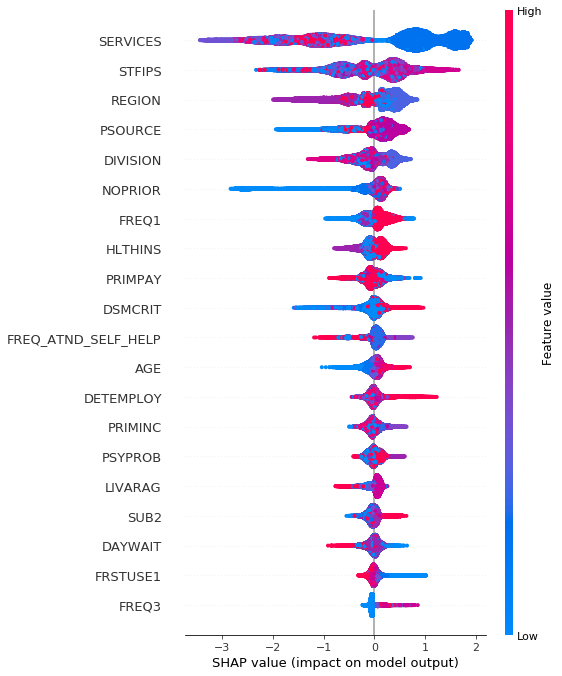

In [35]:
# Plot Shapley summary plot
shap.summary_plot(shap_values, X_test)

In [36]:
shap.initjs()

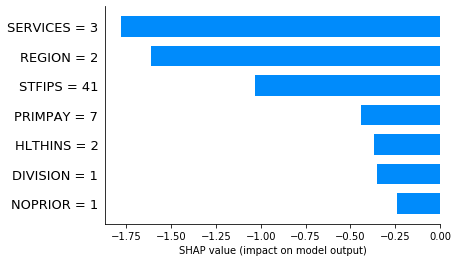

In [37]:
shap.bar_plot(shap_values=shap_values[0].values, features=X_test.iloc[0,:])

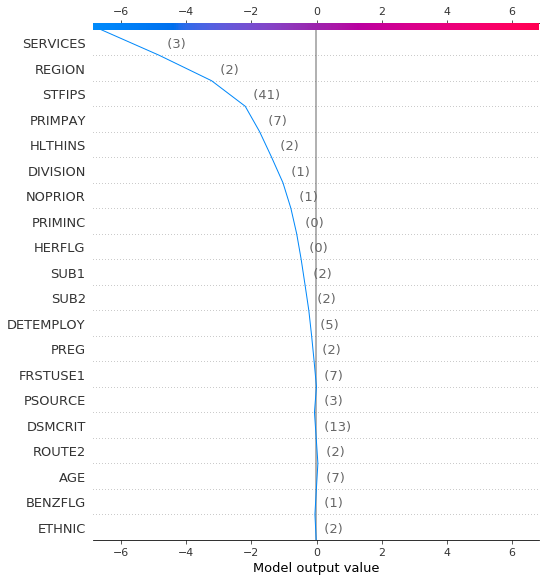

In [38]:
# Decision plot for single sample
shap.decision_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0,:])

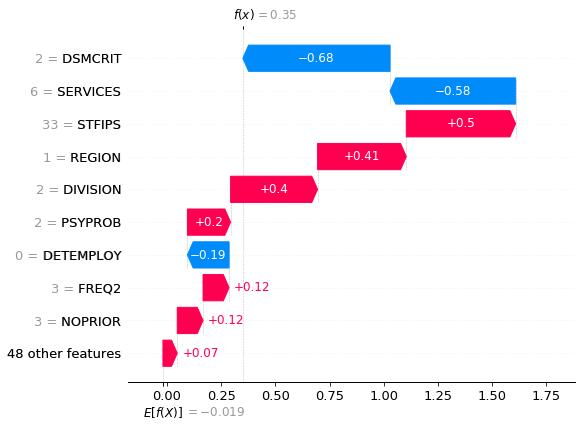

In [160]:
# shap_values[0].values
shap.waterfall_plot(shap_values=shap_values[1])

In [40]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values=shap_values[0].values, features=X_test.iloc[0,:])

# Plot Shalpey values

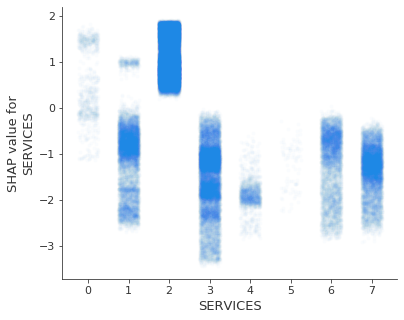

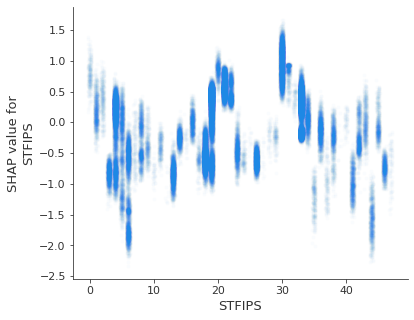

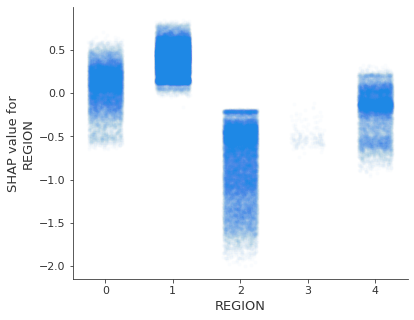

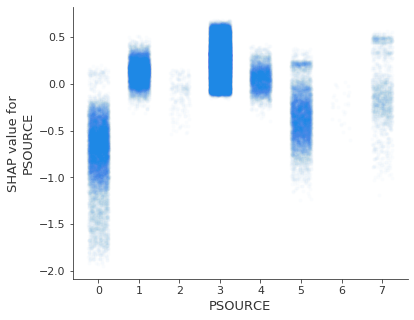

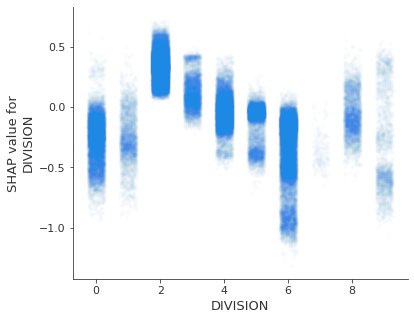

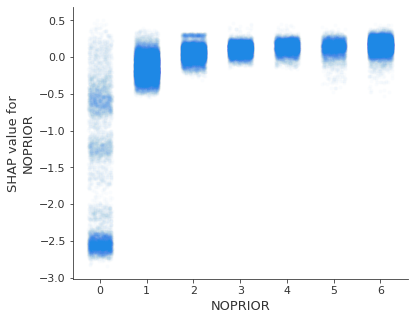

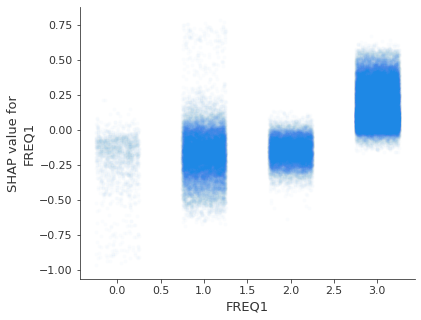

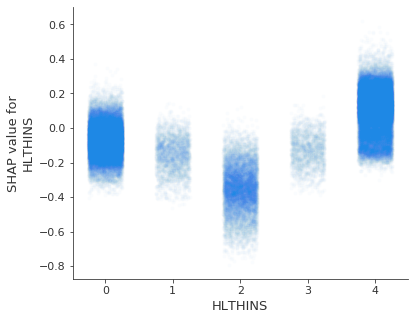

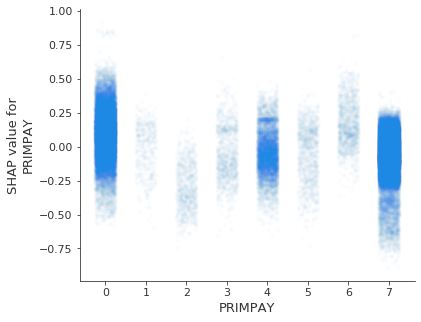

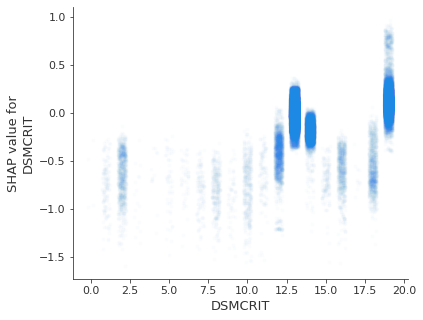

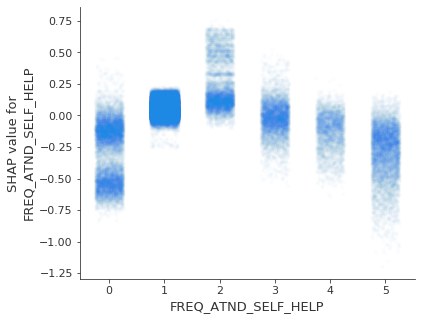

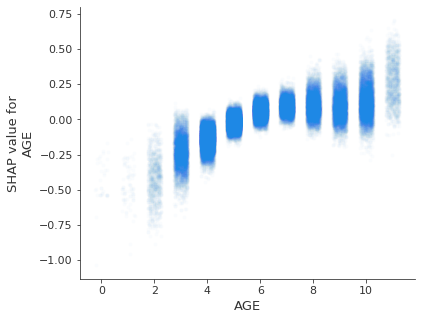

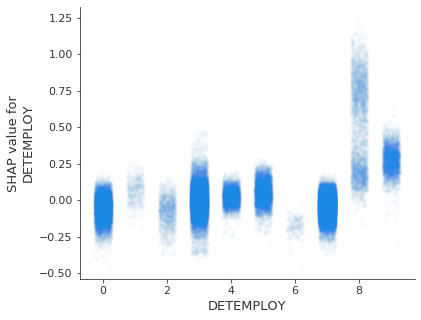

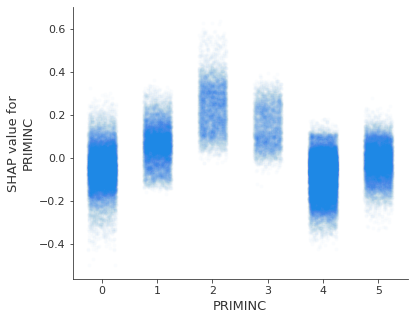

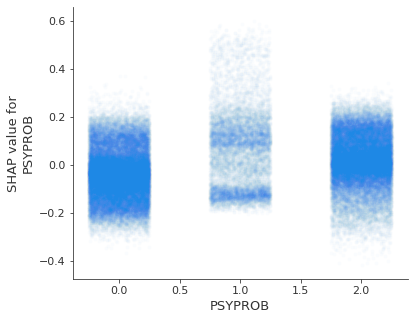

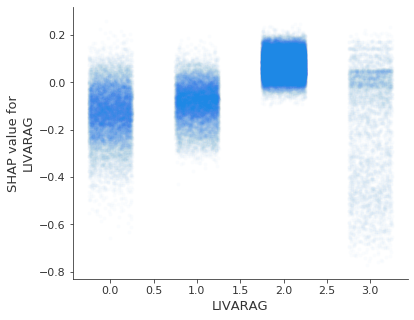

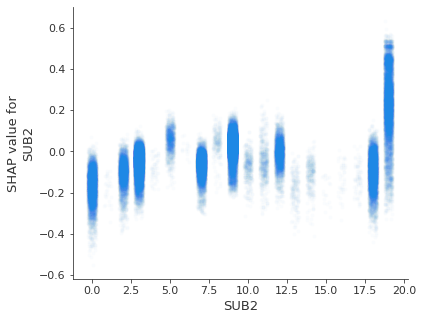

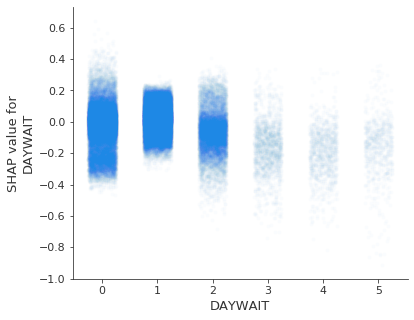

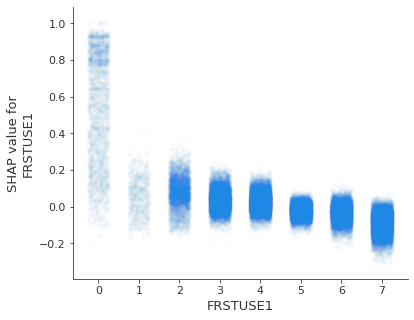

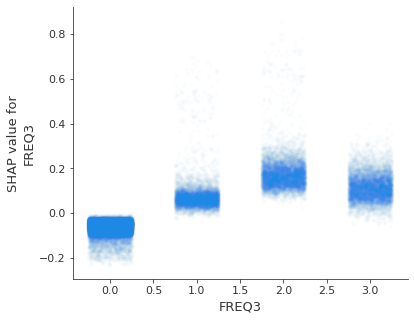

In [164]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
top_features = shap_importance['feature_name'][0:20]
for feature in top_features:
    shap.dependence_plot(feature, shap_values.values, X_test, x_jitter=0.5, alpha=0.02, interaction_index=None)

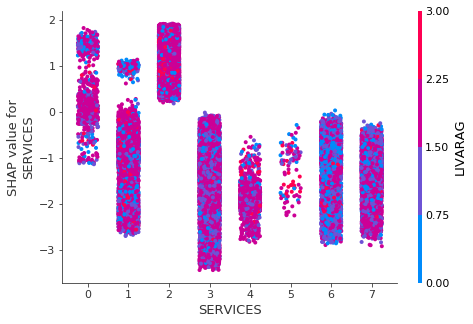

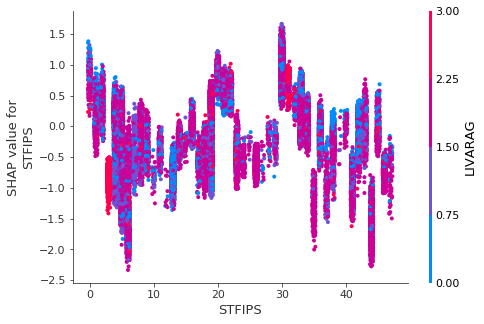

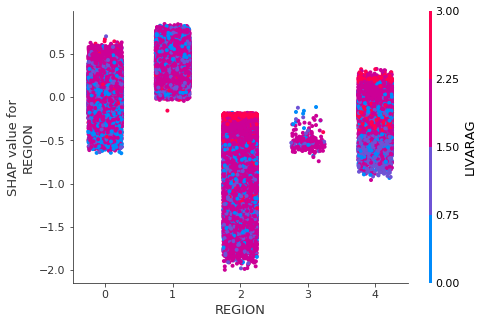

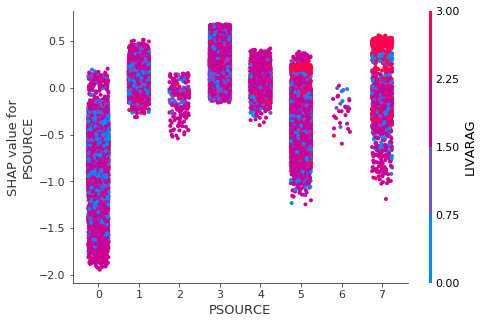

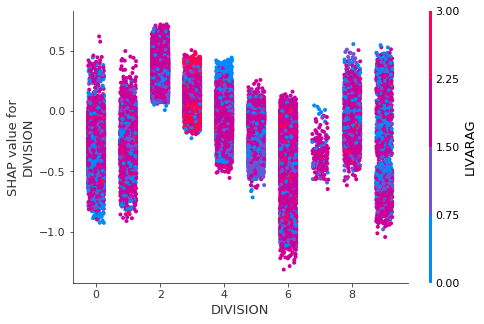

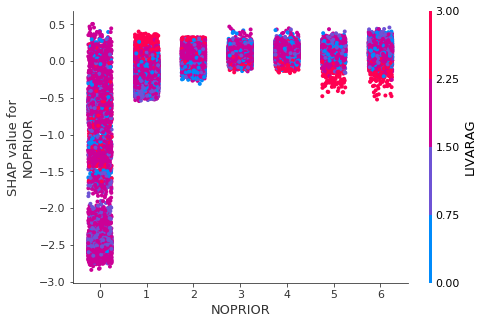

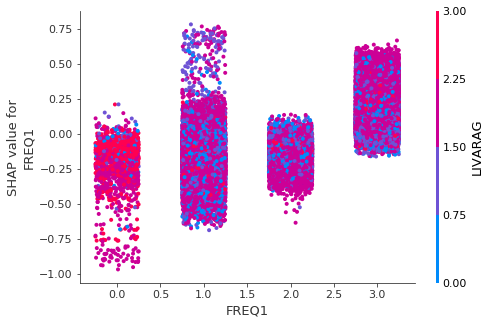

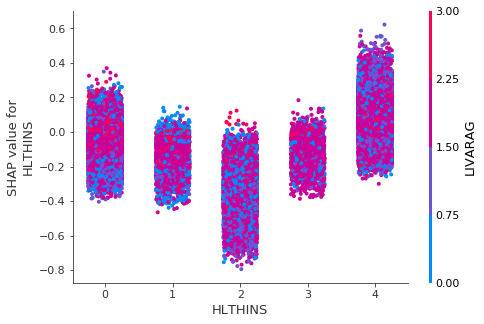

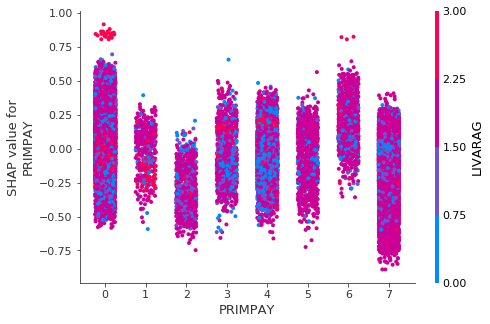

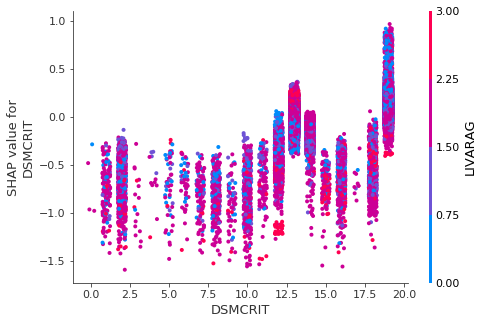

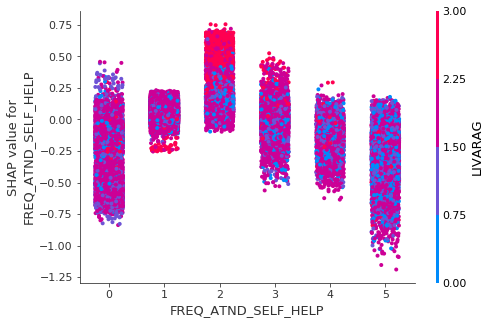

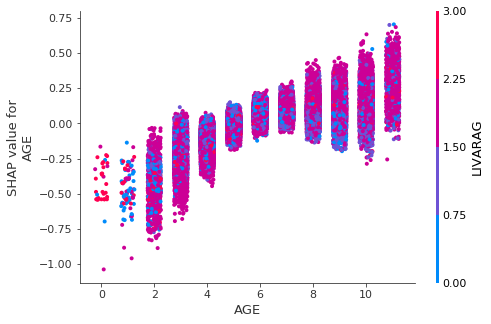

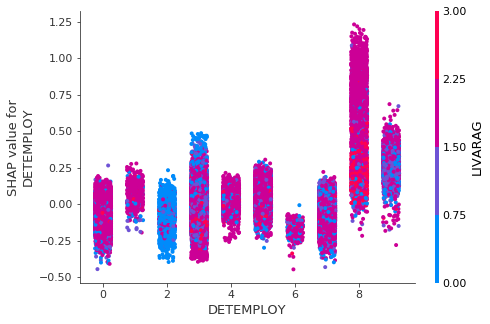

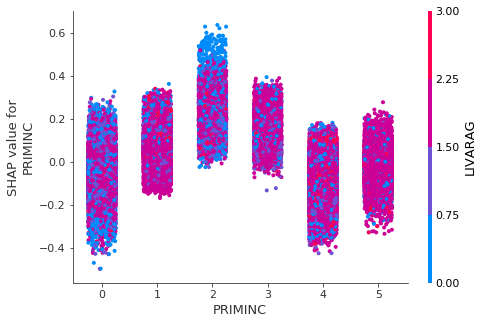

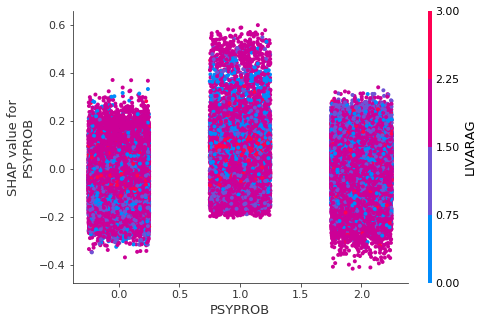

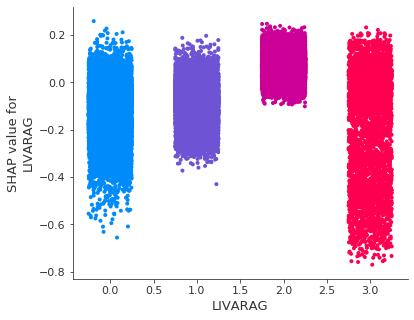

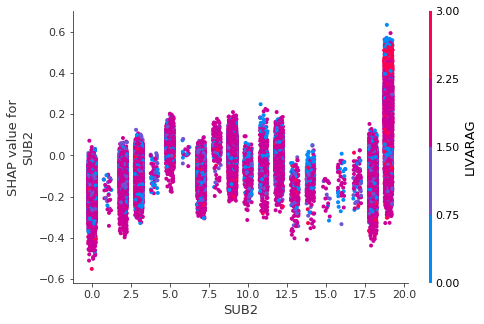

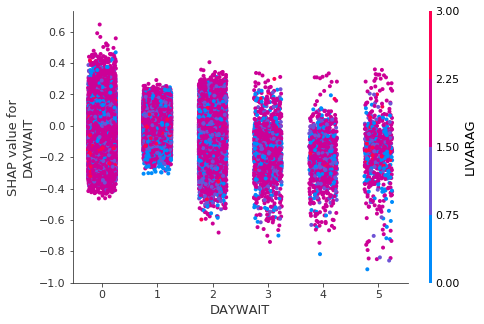

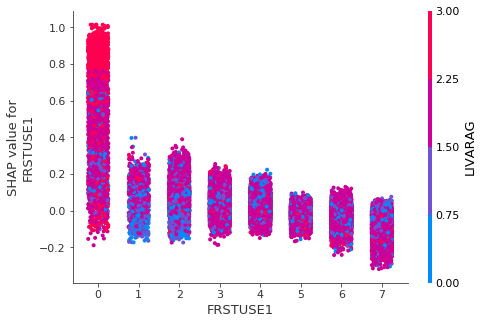

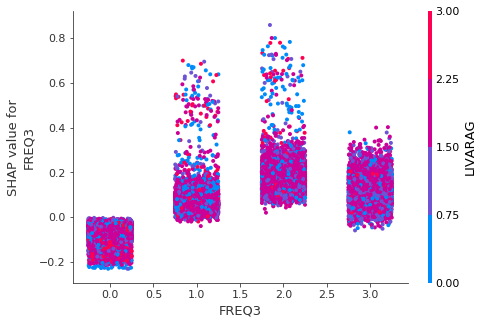

In [90]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
top_features = shap_importance['feature_name'][0:20]
top_features = top_features.reset_index(drop=True)
for feature in top_features:
    shap.dependence_plot(feature, shap_values.values, X_test, x_jitter=0.5, alpha=1, interaction_index=top_features[15])
    # shap.dependence_plot(feature, shap_values.values, X_test, x_jitter=0.5, alpha=0.05, interaction_index=top_features[15])

In [88]:
# print(top_features[0], top_features[3])
print(top_features)

0                SERVICES
1                  STFIPS
2                  REGION
3                 PSOURCE
4                DIVISION
5                 NOPRIOR
6                   FREQ1
7                 HLTHINS
8                 PRIMPAY
9                 DSMCRIT
10    FREQ_ATND_SELF_HELP
11                    AGE
12              DETEMPLOY
13                PRIMINC
14                PSYPROB
15                LIVARAG
16                   SUB2
17                DAYWAIT
18               FRSTUSE1
19                  FREQ3
Name: feature_name, dtype: object


In [99]:
shap_importance
# shap_importance.to_csv('shap_importance.csv')

,feature_name,feature_importance,abs_feature_importance
3,SERVICES,1.204786,0.212295
0,STFIPS,0.516999,0.091100
53,REGION,0.446149,0.078616
6,PSOURCE,0.308769,0.054408
52,DIVISION,0.266251,0.046916
5,NOPRIOR,0.265959,0.046865
25,FREQ1,0.176536,0.031107
31,HLTHINS,0.148397,0.026149
32,PRIMPAY,0.140975,0.024841
14,DSMCRIT,0.138571,0.024418


# Grouped feature importance

In [106]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')
g

,index,feature_name,feature_label,feature_category,feature_importance,abs_feature_importance
0,3,SERVICES,treatment service,coordination of care,1.204786,0.212295
1,0,STFIPS,state code,geographic,0.516999,0.091100
2,53,REGION,census region,geographic,0.446149,0.078616
3,6,PSOURCE,referral source,coordination of care,0.308769,0.054408
4,52,DIVISION,census division,geographic,0.266251,0.046916
5,5,NOPRIOR,prior treatments,medical history,0.265959,0.046865
6,25,FREQ1,primary frequency,substance use history,0.176536,0.031107
7,31,HLTHINS,health insurance,economic,0.148397,0.026149
8,32,PRIMPAY,dsm diagnosis,medical history,0.140975,0.024841
9,14,DSMCRIT,payment source,economic,0.138571,0.024418


In [107]:
g_grouped = g.groupby('feature_category').sum()['abs_feature_importance'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
coordination of care     0.296157
geographic               0.216632
substance use history    0.189463
medical history          0.124266
economic                 0.101987
personal history         0.035936
demographic              0.035560
Name: abs_feature_importance, dtype: float64

In [108]:
g.sort_values(by='abs_feature_importance', ascending=False)[['feature_label', 'abs_feature_importance']].reset_index(drop=True)

,feature_label,abs_feature_importance
0,treatment service,0.212295
1,state code,0.091100
2,census region,0.078616
3,referral source,0.054408
4,census division,0.046916
5,prior treatments,0.046865
6,primary frequency,0.031107
7,health insurance,0.026149
8,dsm diagnosis,0.024841
9,payment source,0.024418


In [ ]:
stop

# Impact of gender on treatment

In [138]:
dfg = df2.copy()
dfg

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,PSYPROB,...,BENZFLG,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,IDU,ALCDRUG,DETEMPLOY
0,AK,Grade9To11,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,Individual,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,AlcoholAndDrugs,Unemployed
1,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,2PriorTreatments,OtherHealthCareProvider,0Arrest,MethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,OtherNotInLaborForce
2,AK,Grade8OrLess,NowMarried,AmbulatoryNonIntensiveOutpatient,Unknown,5PlusPriorTreatments,DrugCareProvider,0Arrest,MethUse,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,RetiredOrDisabled
3,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,OtherHealthCareProvider,0Arrest,MethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,OtherNotInLaborForce
4,AK,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,1PriorTreatments,DrugCareProvider,0Arrest,MethUse,Yes,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,IDU,OtherDrugs,PartTime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524129,WY,Unknown,NowMarried,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,OtherReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,Unemployed
524130,WY,Unknown,NowMarried,AmbulatoryIntensiveOutpatient,Court,2PriorTreatments,CourtReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,Unemployed
524131,WY,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Unknown,3PriorTreatments,DrugCareProvider,0Arrest,NoMethUse,Yes,...,NotReported,NotReported,NotReported,Reported,NotReported,NotReported,NotReported,NoIDU,AlcoholAndDrugs,Unemployed
524132,WY,Grade8OrLess,NeverMarried,AmbulatoryNonIntensiveOutpatient,ProbationOrParole,0PriorTreatments,CourtReferral,0Arrest,NoMethUse,No,...,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NotReported,NoIDU,OtherDrugs,InstitutionResident


In [163]:
def remove_item_from_list(old_list, item):
    new_list = []
    for i in old_list:
        if i != item:
            new_list.append(i)
    return new_list

# def add_new_row(dataset, category):
#     new_row_list = [category]*len(dataset.columns)
#     new_row_series = pd.Series(new_row_list, index=dataset.columns)
#     dataset = dataset.append(new_row_series, ignore_index=True)
#     return dataset

def add_new_row(dataset, category):
    new_row_list = [category]*len(dataset.columns)
    new_row = pd.DataFrame(new_row_list, index=df_temp.columns)
    new_row = new_row.transpose()
    dataset = pd.concat([dataset, new_row],  ignore_index=True)
    return dataset

def add_percent_difference_column(dataset, comparison_col, reference_col):
    numerator = (df_freq[comparison_col]-df_freq[reference_col]).astype("float64")
    denominator = df_freq[reference_col].astype("float64")
    new_col_name = comparison_col + reference_col + 'PercentDifference'
    dataset[new_col_name] = 100*numerator/denominator
    return dataset


In [105]:
import pandas as pd

# Your existing DataFrame
df = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})

# Your new row as a Series
new_row_series = pd.DataFrame({'A': [5], 'B': [6]})

# Concatenate the existing DataFrame with the new row and specify an index
df = pd.concat([df, new_row_series],  ignore_index=True)

# Display the updated DataFrame
print(df)

   A  B
0  1  3
1  2  4
2  5  6


In [145]:
# # Group dataframe by variable of interest
df_freq = pd.DataFrame()
df_temp = dfg.groupby('LIVARAG')['METHUSE'].value_counts().unstack(fill_value=0)
df_temp = (df_temp.div(df_temp.sum(axis=1), axis=0) * 100).round(2)
# df_temp = add_new_row(df_temp, 'DV')

new_row_list = ['DV']*len(df_temp.columns)
new_row_series = pd.DataFrame(new_row_list, index=df_temp.columns)
new_row_series = new_row_series.transpose()
# dataset = df_temp.append(new_row_series, ignore_index=True)
pd.concat([df_temp, new_row_series],  ignore_index=True)
# print(new_row_series.transpose())
# df_temp

METHUSE,MethUse,NoMethUse
0,34.54,65.46
1,28.56,71.44
2,44.92,55.08
3,41.41,58.59
4,DV,DV


In [169]:
# Group dataframe by variable of interest
df_freq = pd.DataFrame()
df_temp = dfg.groupby('LIVARAG')['METHUSE'].value_counts().unstack(fill_value=0)
df_temp = (df_temp.div(df_temp.sum(axis=1), axis=0) * 100).round(2)
df_temp = add_new_row(df_temp, 'DV')
df_freq = pd.concat([df_freq, df_temp], axis=1)


# Refine list of remaining columns
dfg_columns = dfg.columns.tolist()
dfg_columns = remove_item_from_list(dfg_columns, 'LIVARAG')
dfg_columns = remove_item_from_list(dfg_columns, 'METHUSE')

# col = dfg_columns[0]
# # Group by category and calculate the % frequency within each group
# df_temp = dfg.groupby('LIVARAG')[col].value_counts().unstack(fill_value=0)
# df_temp = (df_temp.div(df_temp.sum(axis=0), axis=1) * 100)
# # Add category, then combine dataframes
# df_temp = add_new_row(df_temp, col)
# df_freq = pd.concat([df_freq, df_temp], axis=1)
# df_freq

# Loop through and columns
for col in dfg_columns:
    # Group by category and calculate the % frequency within each group
    df_temp = dfg.groupby('LIVARAG')[col].value_counts().unstack(fill_value=0)
    df_temp = (df_temp.div(df_temp.sum(axis=0), axis=1) * 100)
    # Add category, then combine dataframes
    df_temp = add_new_row(df_temp, col)
    df_freq = pd.concat([df_freq, df_temp], axis=1)

# Reverse the row order and transpose
df_freq = df_freq[::-1].reset_index(drop=True)
df_freq = df_freq.transpose()

# Rename index, columns
df_freq = df_freq.reset_index()
df_freq.insert(2, 'Variable', df_freq['index'])
df_freq = df_freq.drop('index', axis=1)
df_freq = df_freq.rename(columns={0:'Category', 1:'Unknown', 2:'IndependentLiving', 3:'Homeless', 4:'DependLiving'})

# Calculate percent difference
add_percent_difference_column(df_freq, 'Homeless', 'IndependentLiving')
df_freq = df_freq.round(2)

df_freq

,Category,Variable,Unknown,IndependentLiving,Homeless,DependLiving,HomelessIndependentLivingPercentDifference
0,DV,MethUse,41.41,44.92,28.56,34.54,-36.42
1,DV,NoMethUse,58.59,55.08,71.44,65.46,29.70
2,STFIPS,AK,3.49345,59.638178,20.77355,16.094822,-65.17
3,STFIPS,AL,3.896779,55.732594,6.563907,33.80672,-88.22
4,STFIPS,AR,0.154083,58.397535,10.426297,31.022085,-82.15
...,...,...,...,...,...,...,...
330,DETEMPLOY,RetiredOrDisabled,1.893695,73.689228,14.564708,9.852369,-80.23
331,DETEMPLOY,Student,5.381166,65.807175,6.165919,22.64574,-90.63
332,DETEMPLOY,Unemployed,3.578052,59.598677,18.613289,18.209981,-68.77
333,DETEMPLOY,Unknown,26.11034,61.736641,5.803262,6.349757,-90.60


# Portal Add t-test

In [188]:
df2_homeless

,positive_homeless_shapley_value,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,METHUSE,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
273595,False,MI,Grade9To11,Separated,Detox24hFreeStandingRes,Unknown,4PriorTreatments,Individual,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,NoIDU,OtherDrugs,FullTime
167512,False,KY,Grade12OrGED,NeverMarried,AmbulatoryNonIntensiveOutpatient,Court,0PriorTreatments,CourtReferral,1Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastSouthCentral,South,IDU,OtherDrugs,Unemployed
254960,False,MA,Grade8OrLess,NeverMarried,Detox24hFreeStandingRes,Unknown,5PlusPriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
303157,False,NY,Grade12OrGED,Unknown,Detox24hFreeStandingRes,Unknown,Unknown,DrugCareProvider,Unknown,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,MiddleAtlantic,Northeast,IDU,OtherDrugs,Unemployed
140446,False,MI,Grade12OrGED,NeverMarried,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,Individual,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,IDU,Alcohol&Drugs,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49624,False,MA,Grade12OrGED,NeverMarried,Detox24hFreeStandingRes,Unknown,5PlusPriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,NewEngland,Northeast,IDU,OtherDrugs,OtherNotInLaborForce
350516,False,MI,1To3yCollege,NeverMarried,RehabResShortTerm,Unknown,5PlusPriorTreatments,DrugCareProvider,0Arrest,1,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastNorthCentral,Midwest,IDU,OtherDrugs,Unemployed
226269,False,CA,Grade12OrGED,Unknown,Detox24hFreeStandingRes,Unknown,0PriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,Pacific,West,NoIDU,OtherDrugs,UnknownNotInLaborForce
57637,False,TN,Grade12OrGED,DivorcedOrWidowed,AmbulatoryIntensiveOutpatient,Unknown,0PriorTreatments,Individual,0Arrest,0,...,NotReported,NotReported,NotReported,NotReported,NotReported,EastSouthCentral,South,NoIDU,Alcohol&Drugs,FullTime


In [211]:
# Compare homeless subgroups with +/- Shapley values X_test_homeless
# Group dataframe by variable of interest
df_freq = pd.DataFrame()

# mask = df2_homeless.applymap(type) != bool
# replacement = df2_homeless.replace({True: 'T', False: 'F'})
# df2_homeless = df2_homeless.where(mask, replacement)

df_temp = df2_homeless.groupby('positive_homeless_shapley_value')['METHUSE'].value_counts().unstack(fill_value=0)
df_temp = (df_temp.div(df_temp.sum(axis=1), axis=0) * 100).round(2)
df_temp = add_new_row(df_temp, 'DV')
df_freq = pd.concat([df_freq, df_temp], axis=1)

# Refine list of remaining columns
dfg_columns = df2_homeless.columns.tolist()
dfg_columns = remove_item_from_list(dfg_columns, 'positive_homeless_shapley_value')
dfg_columns = remove_item_from_list(dfg_columns, 'METHUSE')

# Loop through and columns
for col in dfg_columns:
    # Group by category and calculate the % frequency within each group
    df_temp = df2_homeless.groupby('positive_homeless_shapley_value')[col].value_counts().unstack(fill_value=0)
    df_temp = (df_temp.div(df_temp.sum(axis=1), axis=0) * 100)
    # Add category, then combine dataframes
    df_temp = add_new_row(df_temp, col)
    df_freq = pd.concat([df_freq, df_temp], axis=1)

# Reverse the row order and transpose
df_freq = df_freq[::-1].reset_index(drop=True)
df_freq = df_freq.transpose()

# Rename index, columns
df_freq = df_freq.reset_index()
df_freq.insert(2, 'Variable', df_freq['index'])
df_freq = df_freq.drop('index', axis=1)
df_freq = df_freq.rename(columns={0:'Category', 1:'PositiveShap', 2:'NegativeShap'})

# Calculate percent difference
add_percent_difference_column(df_freq, 'PositiveShap', 'NegativeShap')
df_freq = df_freq.round(2)

df_freq
# df2_homeless

,Category,Variable,PositiveShap,NegativeShap,PositiveShapNegativeShapPercentDifference
0,DV,0,57.66,64.3,-10.33
1,DV,1,42.34,35.7,18.60
2,STFIPS,AK,1.225627,0.299243,309.58
3,STFIPS,AL,0.557103,0.343249,62.30
4,STFIPS,AR,0.557103,0.21123,163.74
...,...,...,...,...,...
339,DETEMPLOY,RetiredOrDisabled,6.908078,6.521739,5.92
340,DETEMPLOY,Student,0.167131,0.07041,137.37
341,DETEMPLOY,Unemployed,55.933148,39.456082,41.76
342,DETEMPLOY,Unknown,1.78273,1.619433,10.08


In [207]:
df2_homeless #.loc[273595]['positive_homeless_shapley_value']
df2_homeless.groupby('positive_homeless_shapley_value')['METHUSE'].value_counts().unstack(fill_value=0)

METHUSE,0,1
positive_homeless_shapley_value,,
FALSE,7306,4056
TRUE,1035,760
